In [1]:
import cudf
from cuml.datasets import make_blobs
from cuml.neighbors import NearestNeighbors as cuNearestNeighbors

In [76]:
import numpy as np
import sys
import os
import argparse
import pickle
import fnmatch
from tqdm import tqdm
import re
import itertools
import random
import argparse
import matplotlib.pyplot as plt

ROOTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/'
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier = 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'

hier_idx = 4
layer = 'layer_2_Linear'
num_subsamples = 100
k = 100

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g2r2sck2 because the default path (/home/gretatu/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
def main(raw_args=None):
    # Mapping specific
    parser = argparse.ArgumentParser(description='Compute KNN')
    parser.add_argument('--ROOTDIR', default='/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/', type=str)
    parser.add_argument('--model_identifier', default='NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed',
                        type=str, help='Model ID str')
    parser.add_argument('--train_identifier', default='epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06', type=str)
    parser.add_argument('--analyze_identifier', default='mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5', type=str)
    parser.add_argument('--layer', default='layer_2_Linear', type=str, help='Model layer of interest')
    parser.add_argument('--num_subsamples', default='100', type=str, help='Number of subsamples per time point')
    parser.add_argument('--hier_idx', default='4', type=str, help='Hierarchy number, starts at 0 (leaf)')
    parser.add_argument('--k', default='100', type=str, help='Number of neighbors')

    args = parser.parse_args(raw_args)

    print('*' * 40)
    print(vars(args))
    print('*' * 40)
    
    layer = args.layer
    num_subsamples = int(args.num_subsamples)
    hier_idx = int(args.hier_idx)
    k = int(args.k)
    

# Get extracted files for KNN sampling!
# /extracted/mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed/epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06

In [79]:
extracted_files = []
for file in os.listdir(os.path.join(ROOTDIR, 'extracted', analyze_identifier, model_identifier, train_identifier)):
    if fnmatch.fnmatch(file, f'*{layer}_extracted.pkl'):
        extracted_files.append(os.path.join(ROOTDIR, 'extracted', analyze_identifier, model_identifier, train_identifier, file))

assert(len(extracted_files) == 1060)

s = [re.findall('/\d+', x) for x in extracted_files]
s = [item for sublist in s for item in sublist]
dummy_id = [(x.split('/')) for x in s]
file_id = [int(x.split('/')[1]) for x in s]
sorted_files = [extracted_files[x] for x in np.argsort(file_id)]

In [109]:
# Subsample
data = []
targets = []
epochs = []
subepochs = []
train_accs = []
test_accs = []

for i, file in enumerate(sorted_files):
    g = pickle.load(open(file,'rb'))
#     print(file)
    t = file.split('batchidx=')[1]
    batchidx = t.split('_')[0]
    t2 = file.split('epoch=')[1]
    epoch = t2.split('-')[0]
    print(f'Running epoch {epoch}, batchidx {batchidx}')
    projs = g['projection_results']
    hier = np.asarray(projs[hier_idx][layer])
    hier_moved = np.moveaxis(hier, 1, -1)
    if i == 0:
        print(f'Number of classes {hier_moved.shape[0]} for hierarchy {hier_idx}')
    # reshape into # classes, # samples, # features
    hier_moved = np.moveaxis(hier, 1, -1)
    if i == 0:
        print(f'Shape of reshaped tensor: {hier_moved.shape}')

    # flatten samples
    hier_flat = np.reshape(hier_moved, [hier_moved.shape[0]*hier_moved.shape[1], hier_moved.shape[2]])
    if i == 0:
        print(f'Shape of flattened tensor: {hier_flat.shape}')
    
    # ie the first 50 samples (rows) correspond to class 1, the next 50 rows for class 2 etc
    targets_array = np.asarray([[(i+1)]*hier_moved.shape[1] for i in range(hier_moved.shape[0])])
    targets_flatten = targets_array.ravel()
    if i == 0:
        print(f'Targets: {targets_flatten}')

    sample_idx = random.sample(range(hier_flat.shape[0]), num_subsamples)

    subsampled_data = hier_flat[sample_idx, :]
    subsampled_targets = targets_flatten[sample_idx]

    assert(len(subsampled_data) == num_subsamples)
    data.append(subsampled_data)
    targets.append(targets_flatten)
    epochs.append(epoch*num_subsamples)
    subepochs.append(batchidx*num_subsamples)
    train_accs.append(g['train_acc'])
    test_accs.append(g['test_acc'])

Running epoch 01, batchidx 15
Number of classes 4 for hierarchy 4
Shape of reshaped tensor: (4, 50, 208)
Shape of flattened tensor: (200, 208)
Targets: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Running epoch 01, batchidx 30
Running epoch 01, batchidx 45
Running epoch 01, batchidx 60
Running epoch 01, batchidx 75
Running epoch 01, batchidx 90
Running epoch 01, batchidx 105
Running epoch 01, batchidx 120
Running epoch 01, batchidx 135
Running epoch 01, batchidx 150
Running epoch 01, batchidx 165
Running epoch 01, batchidx 180
Running epoch 01, batchidx 195
Running epoch 01, batchidx 210
Running epoch 01, batchidx 225
Running epoc

100.0

In [83]:
assert(len(data) == len(sorted_files))

In [85]:
flat_data = np.asarray([item for sublist in data for item in sublist])

In [87]:
print(f'Shape of flattened final data {flat_data.shape}')

Shape of flattened final data (106000, 208)


In [88]:
production_time = list(range(1, len(epoch))) 
time = list(range(1, len(sorted_files)))
rel_time = np.divide(production_time,max(production_time))

In [89]:
device_data = cudf.DataFrame(flat_data)

In [90]:
knn_cuml = cuNearestNeighbors()
knn_cuml.fit(device_data)
D_cuml, I_cuml = knn_cuml.kneighbors(device_data, num_subsamples)

In [104]:
D = D_cuml.as_matrix()
I = I_cuml.as_matrix()

In [99]:
knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
pkl_name = f'layer={layer}_hier={hier_idx}.pkl'

In [114]:
SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)

In [ ]:
d = {'D':D, 'I':I,
    'train_accs': train_accs, 'test_accs':test_accs,
     'epochs':epochs, 'subepochs':subepochs, 'targets':targets,
     'production_time': production_time, 'time': time, 'rel_time': rel_time
    }

In [112]:
d.keys()

dict_keys(['D', 'I', 'train_accs', 'test_accs', 'epochs', 'subepochs', 'targets', 'production_time', 'time', 'rel_time'])

In [116]:
with open(SAVEDIR + '/' + pkl_name, 'wb') as f:
    pickle.dump(d, f) 

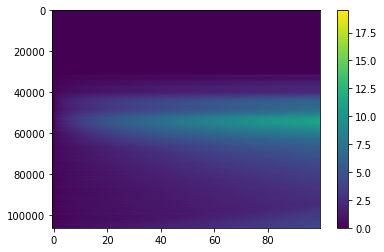

In [93]:
plt.imshow(D_cuml.as_matrix(),aspect='auto',interpolation=None)
plt.colorbar()

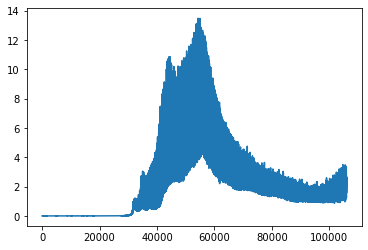

In [97]:
plt.plot(np.mean(D_cuml.as_matrix(),axis=1))

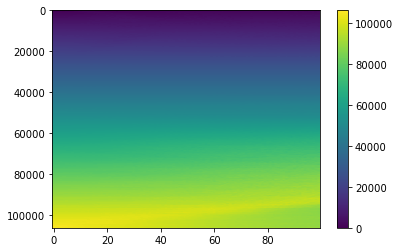

In [94]:
plt.imshow(I_cuml.as_matrix(),aspect='auto',interpolation=None)
plt.colorbar()

In [ ]:
if __name__ == '__main__':
    main()
